In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import DataLoader, random_split
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_data(dir_list, image_size):
    X = []
    y = []
    
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # crop the brain and ignore the unnecessary rest part of the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])  
                
    X = np.array(X)
    y = np.array(y)
    
    
    # Shuffle the data
    X, y = shuffle(X, y)

    # X = torch.tensor(X.transpose(0,3,1,2))

    
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')


    
    return X, y

In [4]:
augmented_path = 'C:/Users/aytem/Desktop/testgit/5820-Final-Project/data'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = augmented_path + '/yes' 
data_no = augmented_path + '/no'


IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [5]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

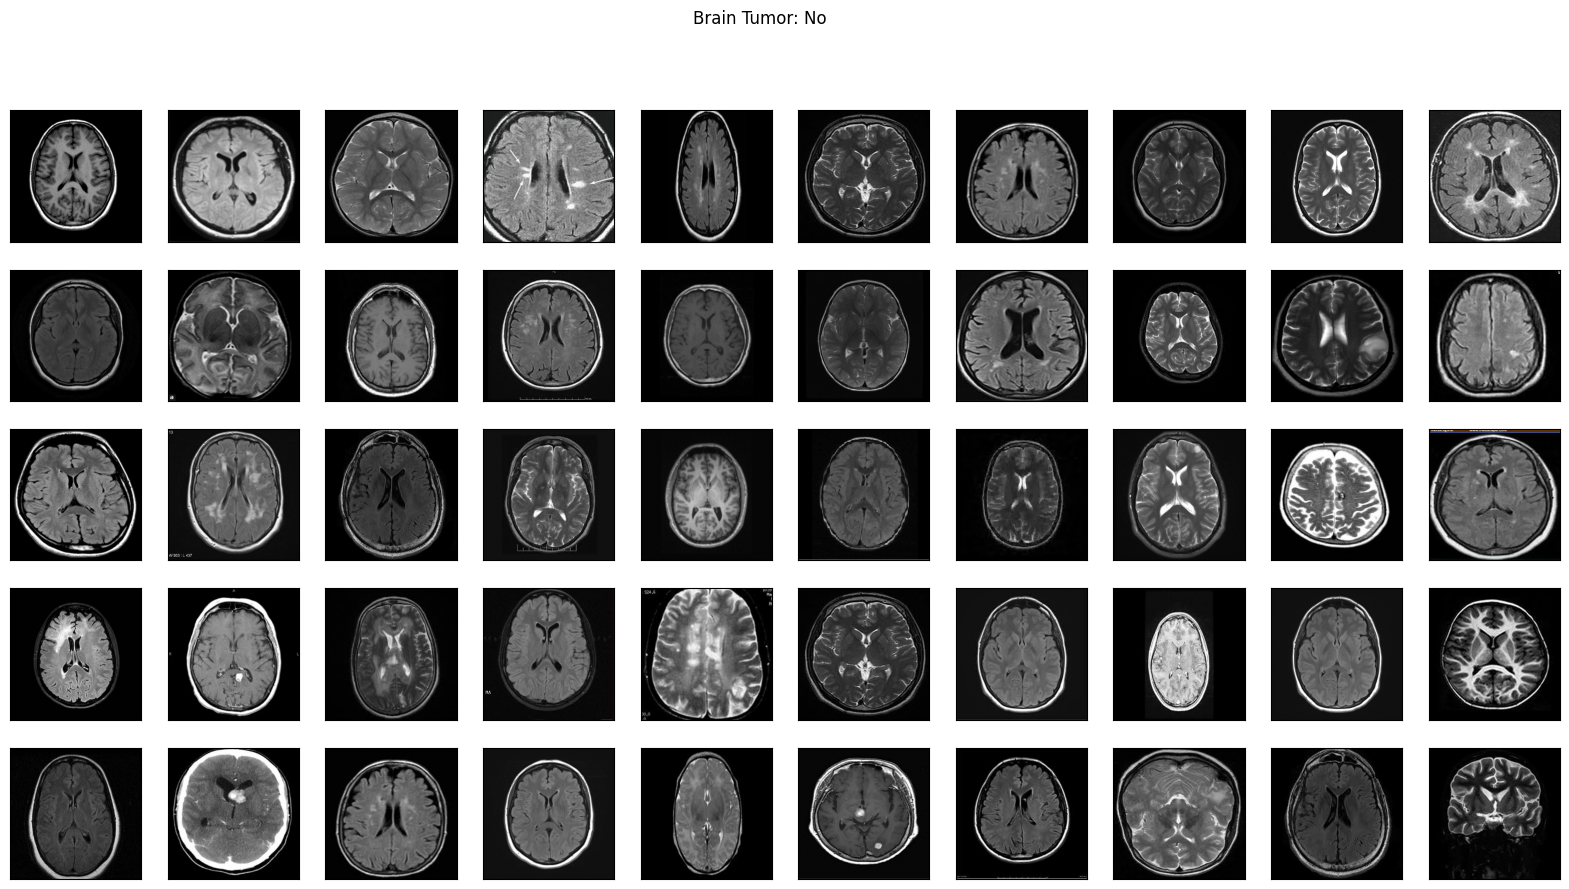

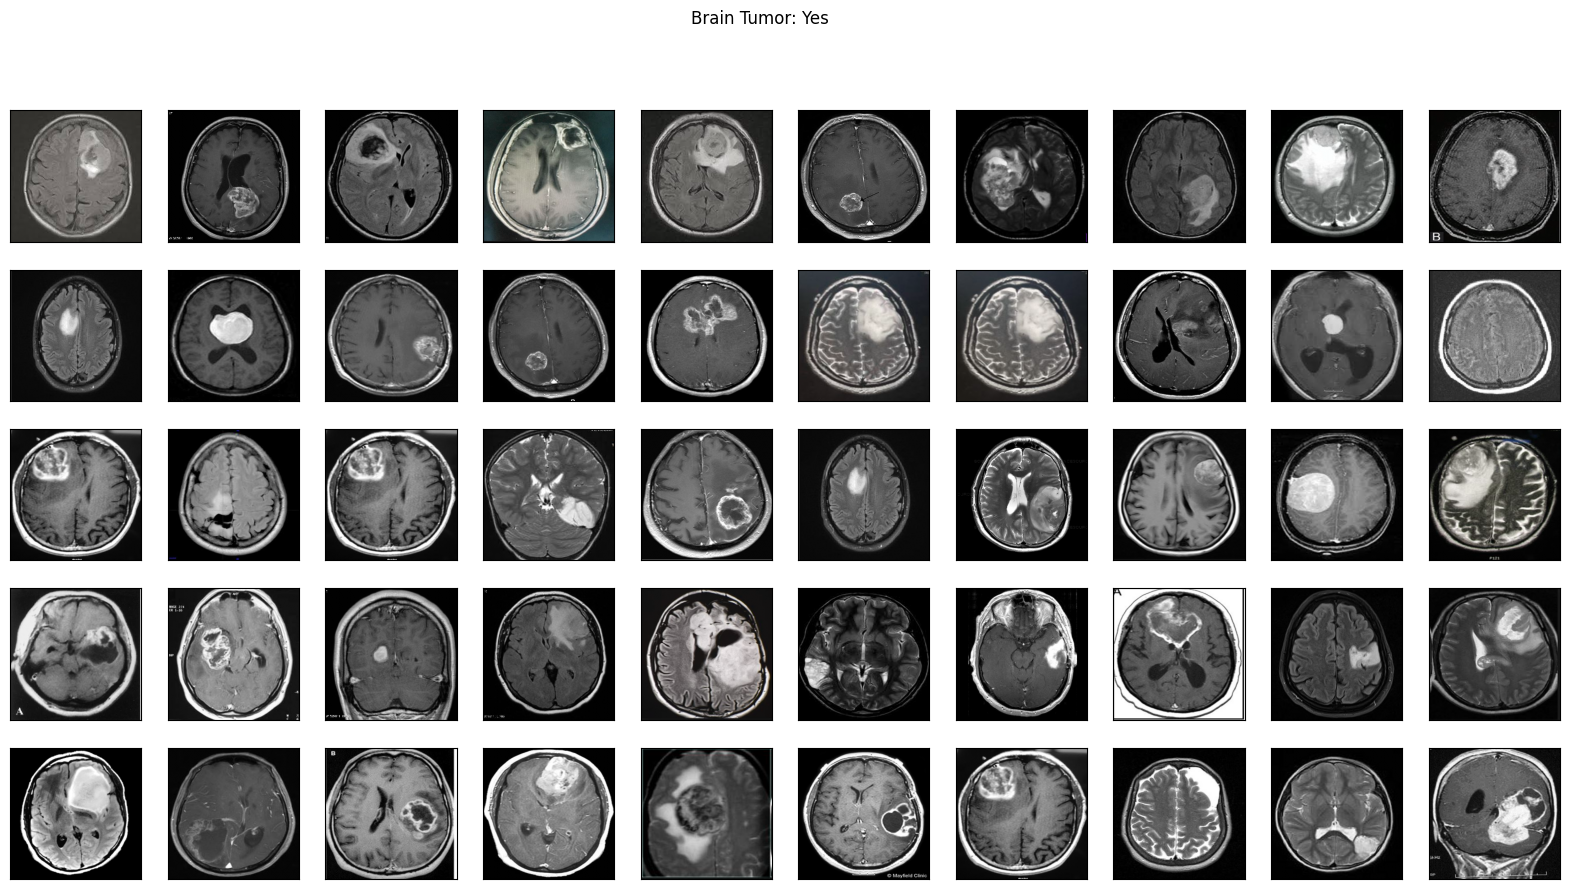

In [6]:
plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = split_data(X, y, test_size=0.3)

In [9]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

training_data = torch.utils.data.TensorDataset(X_train, y_train)
testing_data = torch.utils.data.TensorDataset(X_test, y_test)


In [10]:
import torch.utils
import torch.utils.data

train_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testing_data, batch_size=10, shuffle=False)

In [11]:
print('Training set has {} instances'.format(len(training_data)))
print('Validation set has {} instances'.format(len(testing_data)))

Training set has 177 instances
Validation set has 76 instances


In [12]:
IMG_SHAPE = (240, 240, 3) 
class BrainDetectionModel(nn.Module):
    def __init__(self, input_shape):
        super(BrainDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 4))
        self.fc1 = nn.Linear(6272, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

model = BrainDetectionModel(IMG_SHAPE)


In [13]:
from torchsummary import summary
summary(model, input_size=IMG_SHAPE)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0

In [77]:
val_losses = []
train_losses = []
val_accuracy = []
traning_accuracy = []

def train_dataset(model, train_loader, validation_loader):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    
    num_epochs = 250
    

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs = inputs.transpose(1,3).transpose(2,3)           
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        

        train_acc = correct_train / total_train
        traning_accuracy.append(train_acc)



        print(f"Epoch [{epoch + 1}/250], Loss: {epoch_loss:.4f}")


        

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.transpose(1,3).transpose(2,3)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(validation_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Validation Loss: {val_loss:.4f}")
        y_pred = model(X_test.transpose(1,3).transpose(2,3))
        acc = (y_pred.round() == y_test).float().mean()
        acc = float(acc)

        val_accuracy.append(acc)
        print(f"End of {epoch}, accuracy {acc*100}%")

In [78]:
train_dataset(model, train_loader, validation_loader)

Epoch [1/250], Loss: 0.0564
Validation Loss: 3.7310
End of 0, accuracy 81.57894611358643%
Epoch [2/250], Loss: 0.0227
Validation Loss: 2.8981
End of 1, accuracy 71.05262875556946%
Epoch [3/250], Loss: 0.0005
Validation Loss: 3.0162
End of 2, accuracy 72.36841917037964%
Epoch [4/250], Loss: 0.0004
Validation Loss: 2.9426
End of 3, accuracy 72.36841917037964%
Epoch [5/250], Loss: 0.0004
Validation Loss: 1.9875
End of 4, accuracy 71.05262875556946%
Epoch [6/250], Loss: 0.0001
Validation Loss: 2.9010
End of 5, accuracy 72.36841917037964%
Epoch [7/250], Loss: 0.0002
Validation Loss: 1.7621
End of 6, accuracy 72.36841917037964%
Epoch [8/250], Loss: 0.0001
Validation Loss: 1.8089
End of 7, accuracy 72.36841917037964%
Epoch [9/250], Loss: 0.0001
Validation Loss: 1.8177
End of 8, accuracy 72.36841917037964%
Epoch [10/250], Loss: 0.0001
Validation Loss: 1.8612
End of 9, accuracy 72.36841917037964%


In [79]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, training_accuracy, val_accuracy):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [80]:
train_losses, val_losses, training_accuracy, val_accuracy = train_dataset(model, train_loader, validation_loader)
plot_metrics(train_losses, val_losses, training_accuracy, val_accuracy)

Epoch [1/250], Loss: 0.0990
Validation Loss: 2.1721
End of 0, accuracy 73.68420958518982%
Epoch [2/250], Loss: 0.0029
Validation Loss: 3.7113
End of 1, accuracy 80.26315569877625%
Epoch [3/250], Loss: 0.0006
Validation Loss: 3.7138
End of 2, accuracy 80.26315569877625%
Epoch [4/250], Loss: 0.0002
Validation Loss: 2.6423
End of 3, accuracy 81.57894611358643%
Epoch [5/250], Loss: 0.0001
Validation Loss: 2.6825
End of 4, accuracy 78.94737124443054%
Epoch [6/250], Loss: 0.0001
Validation Loss: 2.6838
End of 5, accuracy 78.94737124443054%
Epoch [7/250], Loss: 0.0001
Validation Loss: 2.7078
End of 6, accuracy 78.94737124443054%
Epoch [8/250], Loss: 0.0001
Validation Loss: 2.7081
End of 7, accuracy 78.94737124443054%
Epoch [9/250], Loss: 0.0000
Validation Loss: 2.6964
End of 8, accuracy 77.63158082962036%
Epoch [10/250], Loss: 0.0001
Validation Loss: 1.5784
End of 9, accuracy 77.63158082962036%


TypeError: cannot unpack non-iterable NoneType object